# Read me

In [97]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv
import time
import json
from pandas.io.json import json_normalize


%matplotlib inline
#import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
import plotly.tools as tls
from pandas import set_option
set_option("display.max_rows", 10)

## Let's build the components of our webscraping script (BeautifulSoup)
First, I will build and test the webscraper on a single date (in this case, 2000-05-06)

In [ ]:
#The standard beautifulsoup incantation to scrape a given URL
url = ('http://www.billboard.com/charts/billboard-200/2000-05-06')
r = requests.get(url)
soup = BeautifulSoup(r.text, "html")
soup.prettify()

#Creating an array containing
top200albums = []
for item in soup.find_all('h2',{'class':'chart-row__song'}):
    top200albums.append(item.string.strip())

#This code below allows us to scrape MULTIPLE TAGS (WOW!) according to class attributes.
#This is handy because the Billboard website has different tags (h2, h3, a) for artistes for some reason.
top200artistes = []
for item in soup.find_all(True, {"class":["chart-row__artist"]}):
    top200artistes.append(item.string.strip())


In [ ]:
# Let's see if the script works
print top200songs
print top200artistes

In [ ]:
#The webscraping script above works! Let's put them into a pandas dataframe so we can unleash the power of pandas on it
#Note that the 'week' column has a .normalize() method. This drops the timestamp(hh:mm:ss) since we don't need it.
chart = pd.DataFrame({'rank': pd.Series(np.arange(1,201,1)),
                     'artiste': pd.Series(top200artistes),
                     'song': pd.Series(top200songs),
                     'week': pd.date_range('2000-05-06', periods = 200, freq='S').normalize()})

#rearranging the column sequence
chart = chart[['artiste', 'song', 'rank', 'week']]
chart

## It works! Let's put it altogether now in a for loop to get our weekly chart data

In [ ]:
#Thankfully, Billboard has a really consistent URL nomenclature. I need only to change the date at the end of the URL.
#Let's build a for loop which creates URLs for each week's top 200 chart, and let's see if these links work

dates = pd.date_range('1963-08-17', periods=3, freq='7D')
dates = dates.strftime('%Y-%m-%d')

for date in dates:
    url = ('http://www.billboard.com/charts/billboard-200/' + str(date))
    print url


In [ ]:
#Let's loop from 1963-08-17 (that's as far back as the Billboard Top 200 goes) to the latest chart on a weekly basis.
#Therell be some missing values/duplicates because the Billboard data sometimes only has top 100 or top 150, but we'll
#deal with this later when we clean the dataset.

#1963-08-17 - 1971-12-11 
#1971-12-18 to 1989-02-18 (periods = 896)
#1989-02-25 to 1994-04-16 (periods = 268)
#1994-04-23 to 2011-07-09 (periods = 899, in process)
#2011-07-16 - present (date?) # 2553 - 2753 (periods = 200)


dates = pd.date_range('1963-08-17', periods=2753, freq='7D') #I've tested that the script works using 'periods = 3'
dates = dates.strftime('%Y-%m-%d')
consolidated_charts = [] # let's create an array to hold each of the weekly arrays
for date in dates:
    try:       #I included a try/except loop to ensure that even if the code breaks, I won't have to start from scratch
        url = ('http://www.billboard.com/charts/billboard-200/' + date)
        r = requests.get(url)
        soup = BeautifulSoup(r.text, "html.parser")

        soup.prettify()

        top200songs = []
        for item in soup.find_all('h2',{'class':'chart-row__song'}):
            top200songs.append(item.string.strip())

        #This code below allows us to scrape MULTIPLE TAGS (WOW!) according to class attributes.
        #This is handy because the Billboard website has different tags (h2, h3, a) for artistes for some reason.
        top200artistes = []
        for item in soup.find_all(True, {"class":["chart-row__artist"]}):
            top200artistes.append(item.string.strip())

        #Buidling the ranking table for that week. Note that the 'week' column has a .normalize() method. This drops the 
        #timestamp(hh:mm:ss) since we're not interested in that.
        chart = pd.DataFrame({'rank': pd.Series(np.arange(1,201,1)),
                             'artiste': pd.Series(top200artistes),
                             'song': pd.Series(top200songs),
                             'week': pd.date_range(date, periods = 200, freq='S').normalize()})



        #rearranging the column sequence
        chart = chart[['artiste', 'song', 'rank', 'week']]

        #appending the chart dataframe to our main dataframe (consolidated_charts)
        consolidated_charts.append(chart)
        time.sleep(11)   #it's v. important that we specify the interval of the loop to give the URL some time to load
                         #and so that www.billboard.com doesn't ban us :p
    except:
        pass
consolidated_charts = pd.concat(consolidated_charts, axis = 0)
    
#This actually took a REALLY long while. 2753 * 11s = 8.4 hrs. It crashed a few times too because I couldn't configure
#my mac to stay awake. I subsequently found a command that worked.  Type in <caffeinate -t 3600> in the command line.
#This keeps the computer awake for 1 hr. You can change the last integer as necessary.


In [ ]:
# It's done! Let's take a look!
consolidated_charts

In [ ]:
#Unfortunately, because it crashed a few times because my laptop went into hibernation, I had to restart the loop a
#few times. Thankfully the try/except loop allowed me to salvage whatever was scraped! Let's merge these csv files
#into one dataframe and save it as one csv file

df1 = pd.read_csv("billboardtop200 1963-08-17 to 1971-12-11.csv")
df2 = pd.read_csv("billboardtop200 1971-12-18 to 1989-02-18.csv")
df3 = pd.read_csv("billboardtop200 1989-02-25 to 1994-04-16.csv")
df4 = pd.read_csv("billboardtop200 1994-04-23 to 1997-06-28.csv")
df5 = pd.read_csv("billboardtop200 1997-07-05 to 2011-07-09.csv")
df6 = pd.read_csv("billboardtop200 2011-07-16 to 2015-05-09.csv")
df7 = pd.read_csv("billboardtop200 2015-05-16 to 2016-05-14.csv")

frames = [df1, df2, df3, df4, df5, df6, df7]
merged = pd.concat(frames)
merged.to_csv("billboardtop200 1963-08-17 to 2016-05-14.csv",  encoding='utf-8')

#Done! Now we have 53 years of billboard charts data to play with!

## Let's clean the data!

There's a couple of things which we need to do:
1. Remove the unnecessary columns (i.e. the first column)
2. Rename "song" column as "album"
3. Convert the values in the "week" column to datetime
4. Check for duplicates and null values and remove them

In [ ]:
#i'm reloading the merged csv file so that we can restart from here if anything blows up later!
merged = pd.read_csv("billboardtop200 1963-08-17 to 2016-05-14.csv")

In [ ]:
merged.info()

#the discrepancy between rank/week and  artiste/song indicates that there are some null objects in artiste/song which
#are not counted by the .info() function. Let's drop these rows containing null objects later

In [ ]:
merged.head()

In [ ]:
#1 & 2. Removing column 1 and renaming the column "song" to "album"
merged.drop(merged.columns[0], axis = 1, inplace = True)
merged.rename(index = str, columns={"song":'album'},inplace=True)
merged.head()

In [ ]:
#3. Convert the values in the "week" column to datetime
merged['week'] = pd.to_datetime(merged.week)
merged.dtypes

In [ ]:
#4. Check for null values and duplicates and remove them
#4.1 Let's check for null values first, since that's easier to do
print merged.album.isnull().value_counts()

#There are 12,831 null rows. let's drop them

merged = merged.dropna(how='any')
print merged.album.isnull().value_counts()

In [ ]:
merged.info()
#no more discrepancies in the number of objects between the columns!

In [ ]:
#4.2 Let's now check for duplicates
#It is highly unlikely that an artiste will appear twice in the weekly top 200 charts, unless the artiste released
#two albums in the same week. So let's identify the instances where the artiste appears twice in a week. To do this,
#we have to temporarily remove the rank column so that we can use the .duplicated() and .drop_duplicates() function.
#These functions identify rows which have identical contents (i.e. same artiste, same album in the  same week)

#let's drop the rank temporarily
merged_withoutrank = merged.drop('rank', axis = 1)


In [ ]:
merged_withoutrank.duplicated().value_counts()

#Aha! 870 duplicates!

In [ ]:
#let's create mask (a series of true/false values) as a tag to identify the duplicates
mask = merged_withoutrank.duplicated()

In [ ]:
print merged[mask == True]

#Let's export this to a csv file for a quick eyeball on whether each of the 870 rows are indeed duplicates.
merged[mask == True].to_csv("billboardtop200 duplicates.csv")

#having taken a look, I vertify that these are indeed duplicates. Two telling pieces of evidence: (i) there are some 
#rows which were duplicated between 5 to 40 times (e.g. Ray Charles' Modern Sounds In Country And Western Music and 
#Jane Fonda's Workout Record (see it for yourself - http://www.billboard.com/charts/billboard-200/1983-07-02)!);
#(ii) the indexes of the rows identified increase by 2 each time (e.g. 131, 133, 135, 137) - meaning that each artiste
#were listed twice in the same chart. Billboard's web developers somehow made this duplication when converting top 100
#charts to top 200 charts.

#We could send this csv file to Billboard if they are interested in fixing this. 

In [ ]:
#Now that we're sure those are duplicates, let's drop them. First we create a new column 'is_duplicate' in the merged
#dataframe
merged['is_duplicate'] = mask
merged[(merged.week == '1963-09-21') & (merged.artiste == 'Ray Charles')]

In [ ]:
merged = merged[merged.is_duplicate == False]
merged.duplicated().value_counts()

#no more duplicates!

In [ ]:
#Let's save this clean dataframe into a new csv file
merged.to_csv("billboardtop200 1963-08-17 to 2016-05-14 (clean).csv",  encoding='utf-8')

## Summarising Groups in the DataFrame
There’s further power put into your hands by mastering the Pandas “groupby()” functionality. Groupby essentially splits the data into different groups depending on a variable of your choice. For example, the expression  data.groupby('month')  will split our current DataFrame by month. The groupby() function returns a GroupBy object, but essentially describes how the rows of the original data set has been split. the GroupBy object .groups variable is a dictionary whose keys are the computed unique groups and corresponding values being the axis labels belonging to each group. For example:

In [13]:
#As before, I'm reloading the clean csv file so that we can restart from here if anything blows up later!
clean = pd.read_csv("billboardtop200 1963-08-17 to 2016-05-14 (clean).csv")

In [14]:
clean.head()


,Unnamed: 0,artiste,album,rank,week,is_duplicate
0,0,Andy Williams,Days Of Wine And Roses,1,1963-08-17,False
1,1,Stevie Wonder,Little Stevie Wonder/The 12 Year Old Genius,2,1963-08-17,False
2,2,Soundtrack,West Side Story,3,1963-08-17,False
3,3,"Peter, Paul & Mary",(Moving),4,1963-08-17,False
4,4,Trini Lopez,Trini Lopez At PJ'S,5,1963-08-17,False


In [15]:
#let's remove the unnecessary columns
clean = clean.drop(clean.columns[[0, 5]], axis = 1) 
clean.head()

,artiste,album,rank,week
0,Andy Williams,Days Of Wine And Roses,1,1963-08-17
1,Stevie Wonder,Little Stevie Wonder/The 12 Year Old Genius,2,1963-08-17
2,Soundtrack,West Side Story,3,1963-08-17
3,"Peter, Paul & Mary",(Moving),4,1963-08-17
4,Trini Lopez,Trini Lopez At PJ'S,5,1963-08-17


In [151]:
clean.artiste.value_counts().head(10)

Soundtrack            23885
Various Artists       14063
The Beatles            2508
The Rolling Stones     1835
Barbra Streisand       1813
Elvis Presley          1689
Elton John             1625
Original Cast          1580
Pink Floyd             1577
Michael Jackson        1408
Name: artiste, dtype: int64

In [19]:
beatles = clean[clean.artiste == 'The Beatles']

In [ ]:
beatles.plot()

## Split-Apply-Combine

Let's play around with the data to see what visualisations we can produce.
1. Let's group the data by artistes, with columns being: (i) number_1, (ii)

In [33]:
no_1 = clean.loc[clean['rank'] == 1]
no_1

,artiste,album,rank,week
0,Andy Williams,Days Of Wine And Roses,1,1963-08-17
149,Stevie Wonder,Little Stevie Wonder/The 12 Year Old Genius,1,1963-08-24
246,Allan Sherman,"My Son, The Nut",1,1963-08-31
395,Allan Sherman,"My Son, The Nut",1,1963-09-07
544,Allan Sherman,"My Son, The Nut",1,1963-09-14
...,...,...,...,...
535899,Zayn,Mind Of Mine,1,2016-04-16
536099,Kanye West,The Life Of Pablo,1,2016-04-23
536299,The Lumineers,Cleopatra,1,2016-04-30
536499,Prince,The Very Best Of Prince,1,2016-05-07


In [54]:
no_1_artiste

0         Andy Williams
149       Stevie Wonder
246       Allan Sherman
395       Allan Sherman
544       Allan Sherman
              ...      
535899             Zayn
536099       Kanye West
536299    The Lumineers
536499           Prince
536699          Beyonce
Name: artiste, dtype: object

In [57]:
no_1_artiste_dates = clean.week.loc[clean['rank'] == 1]

In [148]:
no_1_artiste

0         Andy Williams
149       Stevie Wonder
246       Allan Sherman
395       Allan Sherman
544       Allan Sherman
              ...      
535899             Zayn
536099       Kanye West
536299    The Lumineers
536499           Prince
536699          Beyonce
Name: artiste, dtype: object

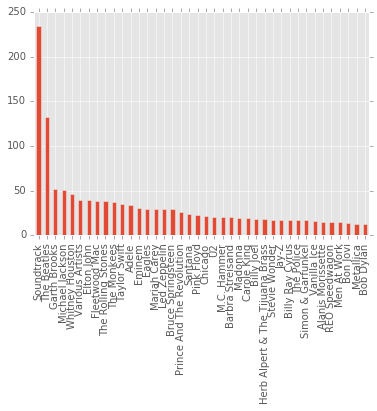

In [49]:
no_1_artiste.value_counts()[:40].plot(kind='bar')